In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats

#import testing
import sys
sys.path.append("../")
import vuong_plots

In [2]:
#generate the sample
def gen_data(beta=0):
    nobs = 500
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*x[:,2] + 1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs

In [3]:
def compute_loglike(resid):
    sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
    ll = np.log(stats.norm.pdf(resid,loc=0,scale=sigma))
    return ll

In [4]:
def compute_score(yn,xn,params):
    
    xn = sm.add_constant(xn)
    resid = yn - np.matmul(xn,params)
    
    k = len(params)
    scale = (resid**2).mean()
    
    tile_resid = np.tile( resid, k)
    tile_resid = np.reshape(tile_resid, (k,xn.shape[0]) ).transpose()
    grad = tile_resid*xn/scale     
    return grad
    
def compute_hess(yn,xn,params):
    pass


def setup_shi(yn,xn):
    x1n,x2n = xn[:,0:2],xn[:,1:3]
    
    # model 1 grad, etc.
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    k1 = (model1_fit.params)
    
    ll1 = compute_loglike(model1_fit.resid)
    grad1 =  compute_score(yn,x1n,model1_fit.params)
    hess1 = model1.hessian(model1_fit.params)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    k2 = (model2_fit.params)
    
    ll2 = compute_loglike(model2_fit.resid)
    grad2 =  compute_score(yn,x2n,model2_fit.params)
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,model1_fit.params, grad2,hess2,model2_fit.params

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

In [5]:
yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

V = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2)
tr_Vsq = (V*V).sum()
V_nmlzd = V/np.sqrt(tr_Vsq) #V, normalized by sqrt(trVsq);

print(V_nmlzd.sum(),V.sum())
print((ll1-ll2).sum()/np.sqrt((ll1-ll2).var()*nobs))
print( (ll1-ll2).sum() )

-0.0920087772294812 -0.385531954332341
0.6958496291807226
14.249045003222317


# Main examples

[[-11.75871831]] 19.40390226892386


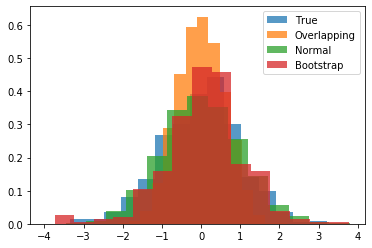

In [6]:
#generate the sample
def gen_data(beta=0):
    nobs = 500
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*x[:,2] + 1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs


true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_recenter(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [7]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean()
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()

sqrt_nobs = np.sqrt(yn.shape[0])
thing3 = sqrt_nobs*(ll1-ll2).mean()/ (ll1-ll2).std()
thing4 = np.array(bootstrap_stats).mean()
print('true mean:%s, eigen: %s, test_stat: %s, boot_mean:%s'%(thing1,thing2,thing3,thing4))

1 --------
0.0 -0.030746433707540953
0.0 0.00047933267566276354
0.0 0.01544212428631875
0.0 31.519494117195492
---------
2 --------
0.9965819278010073 0.9985790859729532
0.36196548116605826 0.36203788874380705
1.0261273666994657 1.026332633226111
156190.0759445857 156712.4507805208
---------
3 --------
-0.15643348956424033 -0.15737648948926022
0.0005591431283057546 0.0005594787708099326
0.04346701610168552 0.04349310848732924
-23104818.079317234 -23337676.226555526
---------
4 --------
3.28719457344664 0.32407606839714187
0.34833754195534955 -0.04462473785053207
3.2374350729395034 0.07999816691390917
122374686614.79187 50851359488.258156
---------
true mean:-0.030746433707540953, eigen: 0.012491077791421779, test_stat: 0.87387221122421, boot_mean:31.519494117195492


[[-33.65118038]] 36.82404679826408


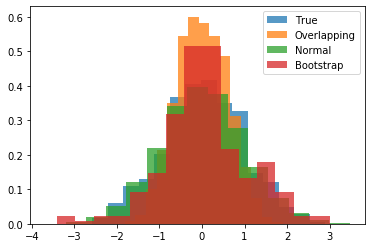

In [8]:
#generate the sample
def gen_data(beta=0):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*x[:,2] + 1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs


true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_recenter(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [9]:
overlap,normal = anayltic_stats
#print moments/kstats
for distr in [true_stats,overlap,normal,bootstrap_stats]:
    print(1, np.array(distr).mean(), stats.kstat(distr, 1))
    print(2, np.array(distr).var(), stats.kstat(distr, 2))
    print(3, stats.skew(distr), stats.kstat(distr, 3) )
    print(4, stats.kurtosis(distr),  stats.kstat(distr, 4) )


1 0.03862914882208611 0.03862914882208611
2 0.9124453337432734 0.9142738815062859
3 -0.06157852387321953 -0.05399451892790165
4 -0.08394018945773363 -0.060760496727971854
1 0.006057216344633766 0.006057216344633766
2 0.3586637093902641 0.3587354564815603
3 0.025218134299101597 0.005420067897303884
4 -0.4111839353179705 -0.052814125209197475
1 0.002400060859829159 0.002400060859829159
2 0.9796926516662928 0.9798886293921715
3 -0.01132497694591665 -0.010988356034484429
4 -0.02185486984235885 -0.01985250592133952
1 68.38765741709189 68.38765741709189
2 600249.9955882673 602257.5206571243
3 -0.06197831468525474 -29113409.432883978
4 0.9396276732898952 353917572093.47986


[[30.68207298]] 2.6184698528860664


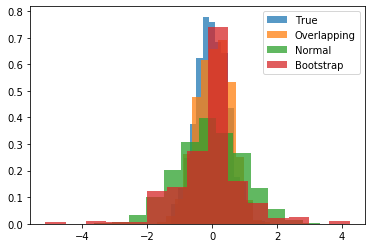

In [10]:
#generate the sample
def gen_data(beta=10):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y =  beta * x[:,1] + e
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_recenter(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [11]:
overlap,normal = anayltic_stats

#print moments/kstats
for distr in [true_stats,overlap,normal,bootstrap_stats]:
    print(1, np.array(distr).mean(), stats.kstat(distr, 1))
    print(2, np.array(distr).var(), stats.kstat(distr, 2))
    print(3, stats.skew(distr), stats.kstat(distr, 3) )
    print(4, stats.kurtosis(distr),  stats.kstat(distr, 4) )
    print('-----------')

1 0.007218838367058225 0.007218838367058225
2 0.24443553039234592 0.2449253811546553
3 0.07157016186823208 0.008701389722941122
4 -0.1703781014204382 -0.009598004132968185
-----------
1 0.054025375082170306 0.054025375082170306
2 0.2754336462556417 0.2754887440044426
3 -0.10545242733882972 -0.01525255810829774
4 -0.2798972966409612 -0.021172650963522065
-----------
1 -0.03498800665851191 -0.03498800665851191
2 1.010136660459311 1.010338728204952
3 -0.015017400402853539 -0.01525546957338537
4 -0.059992377428368826 -0.06007464128804627
-----------
1 -28.29089971280393 -28.29089971280393
2 273174.2019926993 274087.8280863203
3 -0.11378149552897762 -16409155.078242706
4 4.438400328150768 340578367134.4227
-----------


# Other examples

[[-13.33744933]] -0.42119866294547503


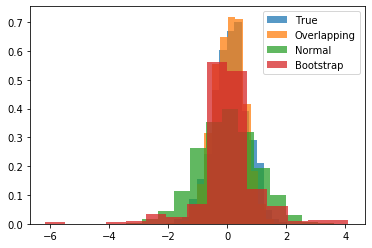

In [12]:
#generate the sample
def gen_data(beta=3):
    nobs = 500
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + .01*x[:,0] + beta * x[:,1] + e
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_recenter(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [13]:
overlap,normal = anayltic_stats

#print moments/kstats
for distr in [true_stats,overlap,normal,bootstrap_stats]:
    print(1, np.array(distr).mean(), stats.kstat(distr, 1))
    print(2, np.array(distr).var(), stats.kstat(distr, 2))
    print(3, stats.skew(distr), stats.kstat(distr, 3) )
    print(4, stats.kurtosis(distr),  stats.kstat(distr, 4) )


1 0.10645783273013683 0.10645783273013683
2 0.3423774990939688 0.3430636263466621
3 -0.11928046235978658 -0.024040154647429746
4 0.06268304038191319 0.008875331232620067
1 0.061407165162849296 0.061407165162849296
2 0.2668331929136737 0.2668865702277193
3 -0.13692718270240556 -0.018884699222430943
4 -0.09053628398513958 -0.006369669243261291
1 0.00359336451174455 0.00359336451174455
2 0.9955015566411483 0.9957006967805043
3 0.025065062150586122 0.02491106650304838
4 0.10063577484676411 0.10106280805205714
1 12.870076924085822 12.870076924085822
2 72482.48013818057 72724.89645971295
3 -0.44649794131209264 -8800839.191543095
4 7.7701139992374095 41895878608.600006


[[-25.75379896]] 15.472367630973032


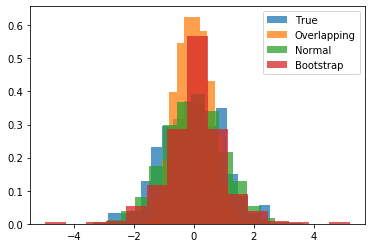

In [14]:
#generate the sample
def gen_data(beta=10):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = .1*x[:,2] + .1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs


true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_recenter(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [15]:
overlap,normal = anayltic_stats

#print moments/kstats
for distr in [true_stats,overlap,normal,bootstrap_stats]:
    print(1, np.array(distr).mean(), stats.kstat(distr, 1))
    print(2, np.array(distr).var(), stats.kstat(distr, 2))
    print(3, stats.skew(distr), stats.kstat(distr, 3) )
    print(4, stats.kurtosis(distr),  stats.kstat(distr, 4) )



1 -0.04074414117691399 -0.04074414117691399
2 1.0129607181703462 1.014990699569485
3 -0.05535851679922608 -0.05677844210566925
4 -0.17511174903119198 -0.16975621345806793
1 -0.005542625741833689 -0.005542625741833689
2 0.3269885639997755 0.32705397479473436
3 0.036986528707059416 0.00691995132477002
4 -0.3215487369026935 -0.03430019543587096
1 0.02463544122909371 0.02463544122909371
2 0.9931378998980214 0.9933365672114637
3 0.0014488272714117793 0.00143480065332335
4 0.016048349881469637 0.01703604380049465
1 41.42859554107473 41.42859554107473
2 282793.4100171641 283739.207375081
3 -0.01900021482218982 -2886140.675181828
4 4.331741450837202 356254309511.6007


[[-92.53444048]] -63.655295323409675


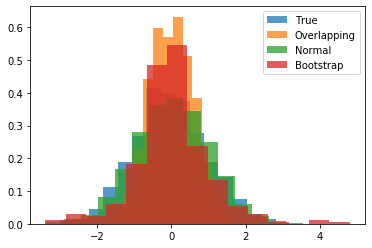

In [16]:
#generate the sample
def gen_data(beta=1):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + 2*x[:,2] + 2*x[:,0] + beta * x[:,1] + e

    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_recenter(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [17]:
overlap,normal = anayltic_stats
#print moments/kstats
for distr in [true_stats,overlap,normal,bootstrap_stats]:
    print(1, np.array(distr).mean(), stats.kstat(distr, 1))
    print(2, np.array(distr).var(), stats.kstat(distr, 2))
    print(3, stats.skew(distr), stats.kstat(distr, 3) )
    print(4, stats.kurtosis(distr),  stats.kstat(distr, 4) )

1 -0.03614076703923165 -0.03614076703923165
2 0.9512430349942089 0.9531493336615319
3 0.08829014191546795 0.0824061396687899
4 -0.10912627028991562 -0.08914936134031015
1 -0.003631644675603111 -0.003631644675603111
2 0.33191379581167774 0.3319801918500477
3 0.04100636425297022 0.007846027776075144
4 -0.3421282759901838 -0.03761162186675384
1 0.030775629809532558 0.030775629809532558
2 1.0060309828460714 1.0062322292919295
3 -0.007672793438726007 -0.007746957272025533
4 -0.019689567163810207 -0.018739725186368066
1 25.872559951088025 25.872559951088025
2 604677.460953785 606699.7935991153
3 0.5429555312270372 257872475.86552072
4 3.4316046937209377 1291889460966.9988
